In [1]:
# SELFACT_CBC.IPYNB - A simple case of resource compeition CBC applied to a self-activating gene
# By Kirill Sechkar

# PACKAGE IMPORTS
import numpy as np
import jax
import jax.numpy as jnp
import functools
import pandas as pd
from bokeh import plotting as bkplot, models as bkmodels, layouts as bklayouts, io as bkio
from bokeh.colors import RGB as bkRGB
import matplotlib as mpl, matplotlib.pyplot as plt

import time

from pandas.tests.resample.test_resample_api import b_mean

# CIRCUIT AND EXTERNAL INPUT IMPORTS
from sim_tools.cell_model import *
import sim_tools.genetic_modules as gms
import sim_tools.controllers as ctrls
import sim_tools.reference_switchers as refsws
import sim_tools.ode_solvers as odesols

# ANALYTICAL BIFURCATION ANALYSIS TOOL IMPORTS
import selfact_an_bif as an_tools

# PROBE BURDEN INTERPOLATOR IMPORTS
from probe_characterisation.probe_char_tools import *

# set up jax
jax.config.update('jax_platform_name', 'cpu')
jax.config.update("jax_enable_x64", True)

# set up bokeh
bkio.reset_output()
bkplot.output_notebook()

# set up matplotlib
%matplotlib widget

locale: Cannot set LC_CTYPE to default locale: No such file or directory
locale: Cannot set LC_MESSAGES to default locale: No such file or directory
locale: Cannot set LC_COLLATE to default locale: No such file or directory


Loading BokehJS ...

In [2]:
# DEFINE CIRCUIT PARAMETERS TO BE CONSIDERED
circ_par={}

# set the parameters for the synthetic genes
 
 # self-activating switch
circ_par['c_switch'] = 100.0
circ_par['a_switch'] = 3000.0
circ_par['k+_switch'] = 60.0 / 100.0

circ_par['baseline_switch'] = 0.05
circ_par['K_switch'] = 250.0
circ_par['I_switch'] = 0.1

# FP reporter maturation
circ_par['mu_ofp'] = 1/(13.6/60)

# chemically cybercontrolled probe
circ_par['c_ta'] = 100.0
circ_par['a_ta'] = 10.0
circ_par['c_b'] = 100.0
circ_par['a_b'] = 5000.0
circ_par['mu_b'] = 1/(13.6/60)

In [3]:
# INITIALISE AND PARAMETERISE THE CELL MODEL

# initialise cell model
cellmodel_auxil = CellModelAuxiliary()  # auxiliary tools for simulating the model and plotting simulation outcomes
cellmodel_par = cellmodel_auxil.default_params()  # get default parameter values
init_conds = cellmodel_auxil.default_init_conds(cellmodel_par)  # get default initial conditions

# add reference tracker switcher
cellmodel_par_with_refswitch, ref_switcher = cellmodel_auxil.add_reference_switcher(cellmodel_par,
                                                                                    # cell model parameters
                                                                                    refsws.no_switching_initialise,
                                                                                    # function initialising the reference switcher
                                                                                    refsws.no_switching_switch
                                                                                    # function switching the references to be tracked
                                                                                    )

# load synthetic genetic modules and the controller
odeuus_complete, \
    module1_F_calc, module2_F_calc, \
    module1_specterms, module2_specterms, \
    controller_action, controller_update, \
    par, init_conds, controller_memo0, \
    synth_genes_total_and_each, synth_miscs_total_and_each, \
    controller_memos, controller_dynvars, controller_ctrledvar, \
    modules_name2pos, modules_styles, controller_name2pos, controller_styles, \
    module1_v_with_F_calc, module2_v_with_F_calc = cellmodel_auxil.add_modules_and_controller(
        # module 1
        gms.sas_initialise,  # function initialising the circuit
        gms.sas_ode,  # function defining the circuit ODEs
        gms.sas_F_calc, # function calculating the circuit genes' transcription regulation functions
        gms.sas_specterms, # function calculating the circuit genes effective mRNA levels (due to possible co-expression from the same operons)
        # module 2
        gms.cicc_initialise,  # function initialising the circuit
        gms.cicc_ode,  # function defining the circuit ODEs
        gms.cicc_F_calc, # function calculating the circuit genes' transcription regulation functions
        gms.cicc_specterms, # function calculating the circuit genes effective mRNA levels (due to possible co-expression from the same operons)
        # controller
        ctrls.cci_initialise,  # function initialising the controller
        ctrls.cci_action,  # function calculating the controller action
        ctrls.cci_ode,  # function defining the controller ODEs
        ctrls.cci_update,  # function updating the controller based on measurements
        # cell model parameters and initial conditions
        cellmodel_par_with_refswitch, init_conds)

# unpack the synthetic genes and miscellaneous species lists
synth_genes = synth_genes_total_and_each[0]
module1_genes = synth_genes_total_and_each[1]
module2_genes = synth_genes_total_and_each[2]
synth_miscs = synth_miscs_total_and_each[0]
module1_miscs = synth_miscs_total_and_each[1]
module2_miscs = synth_miscs_total_and_each[2]

par.update(circ_par)

In [4]:
# GET MAXIMUM BURDENS AND DEGRADATION COEFFICIENTS

# get steady state translation elongation rate and ribosomal gene transcription regulation function for the calculation
e_ss, F_r_ss = an_tools.get_ss_F_and_e(init_conds['s'])

# calculate maximum synthetic gene burdens, native gene burdens, and degradation coefficients
qmaxs, qs_native, chis = an_tools.find_qs_and_chis(e_ss, F_r_ss, par, synth_genes, modules_name2pos)

# record maximum burdens and degradation coefficients in a common dictionary
cellvars={}
cellvars.update(qmaxs)
cellvars.update(qs_native)
cellvars.update(chis)
# add maxmium overall burden from the self-activating switch
cellvars['q_sas_max']=cellvars['q_switch_max']+cellvars['q_ofp_max']
# add ste steady-state translation elongation rate
cellvars['e']=e_ss

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [5]:
# GET THE TWO BIFURCATION POINTS

# for one of them, F_req touches the F_real curve from below; for the other, from above
bif_Freqbelow, bif_Freqabove = an_tools.find_bifurcations(par, cellvars)

In [6]:
# GET THE ANALYTICAL BIFURCATION CURVE

# define the range of probe-exerted burdens to consider
q_probe_range=np.linspace(0.0, 0.5, 20)

# get the bifurcation curve
an_bif_curve = an_tools.find_equilibria_for_q_osynth_range(q_probe_range, 
                                                           bif_Freqbelow, bif_Freqabove,
                                                           par, cellvars)

In [7]:
# PLOT THE ANALYTICAL BIFURCATION CURVE

# p_ofp vs imposed burden
an_ofp_fig = bkplot.figure(
    frame_width=360,
    frame_height=360,
    x_axis_label="q_p, probe burden",
    y_axis_label="ofp_mature, mature output fluorescent protein level",
    x_range=(min(q_probe_range), max(q_probe_range)),
    y_range=(0, max(an_bif_curve['ofp_mature'])),
    title='Analytical bifurcation curve: p_ofp vs imposed burden',
    tools="box_zoom,pan,hover,reset"
)
# plot the controlled variable vs control action
an_ofp_fig.line(x=an_bif_curve['q_osynth'],
             y=an_bif_curve['ofp_mature'],
             line_width=1.5, line_color='black', line_dash='dashed',
             legend_label='true steady states')
an_ofp_fig.scatter(x=an_bif_curve['q_osynth'],
                y=an_bif_curve['ofp_mature'],
                marker='circle', size=5,
                color='black', legend_label='true steady states')
# legend formatting
an_ofp_fig.legend.label_text_font_size = "8pt"
an_ofp_fig.legend.location = "top_right"
an_ofp_fig.legend.click_policy = 'hide'
    
# exreted burden vs imposed burden
an_q_fig = bkplot.figure(
    frame_width=360,
    frame_height=360,
    x_axis_label="q_p, probe burden",
    y_axis_label="q_sas, self-activating switch burden",
    x_range=(0, 0.5),
    y_range=(0, 0.5),
    title='Analytical bifurcation curve: exerted vs imposed burden',
    tools="box_zoom,pan,hover,reset"
)
# plot the controlled variable vs control action
an_q_fig.line(x=an_bif_curve['q_osynth'],
             y=an_bif_curve['q_sas'],
             line_width=1.5, line_color='black', line_dash='dashed',
             legend_label='true steady states')
an_q_fig.scatter(x=an_bif_curve['q_osynth'],
                y=an_bif_curve['q_sas'],
                marker='circle', size=5,
                color='black', legend_label='true steady states')
# legend formatting
an_q_fig.legend.label_text_font_size = "8pt"
an_q_fig.legend.location = "top_right"
an_q_fig.legend.click_policy = 'hide'

# show the plots
bkplot.show(bklayouts.grid([[an_ofp_fig, an_q_fig]]))

In [8]:
# SIMULATE CBC - INITIALISE AND PARAMETERISE THE CELL MODEL

# initialise cell model
cellmodel_auxil = CellModelAuxiliary()  # auxiliary tools for simulating the model and plotting simulation outcomes
cellmodel_par = cellmodel_auxil.default_params()  # get default parameter values
init_conds = cellmodel_auxil.default_init_conds(cellmodel_par)  # get default initial conditions

# add reference tracker switcher
cellmodel_par_with_refswitch, ref_switcher = cellmodel_auxil.add_reference_switcher(cellmodel_par,
                                                                                    # cell model parameters
                                                                                    refsws.timed_switching_initialise,
                                                                                    # function initialising the reference switcher
                                                                                    refsws.timed_switching_switch
                                                                                    # function switching the references to be tracked
                                                                                    )

# load synthetic genetic modules and the controller
odeuus_complete, \
    module1_F_calc, module2_F_calc, \
    module1_specterms, module2_specterms, \
    controller_action, controller_update, \
    par, init_conds, controller_memo0, \
    synth_genes_total_and_each, synth_miscs_total_and_each, \
    controller_memos, controller_dynvars, controller_ctrledvar, \
    modules_name2pos, modules_styles, controller_name2pos, controller_styles, \
    module1_v_with_F_calc, module2_v_with_F_calc = cellmodel_auxil.add_modules_and_controller(
    # module 1
    gms.sas_initialise,  # function initialising the circuit
    gms.sas_ode,  # function defining the circuit ODEs
    gms.sas_F_calc, # function calculating the circuit genes' transcription regulation functions
    gms.sas_specterms, # function calculating the circuit genes effective mRNA levels (due to possible co-expression from the same operons)
    # module 2
    gms.cicc_initialise,  # function initialising the circuit
    gms.cicc_ode,  # function defining the circuit ODEs
    gms.cicc_F_calc,    # function calculating the circuit genes' transcription regulation functions
    gms.cicc_specterms,  # function calculating the circuit genes effective mRNA levels (due to possible co-expression from the same operons)
    # controller
    ctrls.pichem_initialise,  # function initialising the controller
    ctrls.pichem_action,  # function calculating the controller action
    ctrls.pichem_ode,  # function defining the controller ODEs
    ctrls.pichem_update,  # function updating the controller based on measurements
    # cell model parameters and initial conditions
    cellmodel_par_with_refswitch, init_conds)

# unpack the synthetic genes and miscellaneous species lists
synth_genes = synth_genes_total_and_each[0]
module1_genes = synth_genes_total_and_each[1]
module2_genes = synth_genes_total_and_each[2]
synth_miscs = synth_miscs_total_and_each[0]
module1_miscs = synth_miscs_total_and_each[1]
module2_miscs = synth_miscs_total_and_each[2]

par.update(circ_par)

In [9]:
# SIMULATE CBC - SET CONTROLLER AND SIMULATION PARAMETER

controller_ctrledvar='ofp_mature'

# reference p_ofp levels
p_switch_sup = an_tools.find_p_switch_sup(par, cellvars)    # maximum p_switch
_,ofp_mature_sup = an_tools.p_ofp_immat_mat(p_switch_sup, 0.0, par, cellvars)
cbc_refs=np.linspace(0, ofp_mature_sup, 20)
cbc_refs=np.flip(cbc_refs)

# simulation parameters

# switching between references
par['t_burn_in']=24.0
cbc_exp_duration=240.0
par['t_switch_ref']=(cbc_exp_duration/len(cbc_refs))

tf = (0.0, par['t_burn_in']+cbc_exp_duration)  # simulation time
meastimestep = 0.1  # hours

# bang-bang controller parameters
par['inducer_level_on']=100.0
par['on_when_below_ref']=False

# PI controller parameters - gains negative as more probe induction => less p_ofp
par['Kp'] = -0.0005
par['Ki'] = 0.0

# initial control action
u0=0.0

control_delay=0.01

In [10]:
# SIMULATE CBC - RUN THE SIMULATION

# set up the ODE solver
ode_solver, us_size = odesols.create_euler_solver(odeuus_complete,
                                                  control_delay=control_delay,
                                                  meastimestep=meastimestep,
                                                  euler_timestep=1e-5)

# solve ODE
timer= time.time()
ts_jnp, xs_jnp,\
    ctrl_memorecord_jnp, uexprecord_jnp, \
    refrecord_jnp  = ode_sim(par,   # model parameters
                             ode_solver,    # ODE solver for the cell with the synthetic gene circuit
                             odeuus_complete,    # ODE function for the cell with the synthetic gene circuit and the controller (also gives calculated and experienced control actions)
                             controller_ctrledvar,    # name of the variable read and steered by the controller
                             controller_update, controller_action,   # function for updating the controller memory and calculating the control action
                             cellmodel_auxil.x0_from_init_conds(init_conds,
                                                                par,
                                                                synth_genes, synth_miscs, controller_dynvars,
                                                                modules_name2pos,
                                                                controller_name2pos),   # initial condition VECTOR
                             controller_memo0,  # initial controller memory record
                             u0,    # initial control action, applied before any measurement-informed actions reach the system
                             (len(synth_genes), len(module1_genes), len(module2_genes)),    # number of synthetic genes
                             (len(synth_miscs), len(module1_miscs), len(module2_miscs)),    # number of miscellaneous species
                             modules_name2pos, controller_name2pos, # dictionaries mapping gene names to their positions in the state vector
                             cellmodel_auxil.synth_gene_params_for_jax(par, synth_genes),   # synthetic gene parameters in jax.array form
                             tf, meastimestep,  # simulation time frame and measurement time step
                             control_delay,  # delay before control action reaches the system
                             us_size,  # size of the control action record needed
                             cbc_refs, ref_switcher,  # reference values and reference switcher
                             )

# convert simulation results to numpy arrays
ts = np.array(ts_jnp)
xs = np.array(xs_jnp)
ctrl_memorecord = np.array(ctrl_memorecord_jnp)
uexprecord = np.array(uexprecord_jnp)
refrecord= np.array(refrecord_jnp)

# get effective state trajectories - with mRNA levels adjusted for possible co-expression of genes from the same operon
module1_specterms_vmap = jax.vmap(module1_specterms, in_axes=(0, None, None))
module2_specterms_vmap = jax.vmap(module2_specterms, in_axes=(0, None, None))
xs_eff = np.array(jnp.concatenate((xs[:, 0:8],
                                  module1_specterms_vmap(xs, par, modules_name2pos)[0], # eff mRNA concs are the first output of specterms
                                  module2_specterms_vmap(xs, par, modules_name2pos)[0], # eff mRNA concs are the first output of specterms
                                  xs[:, 8 + len(synth_genes):]), axis=1))

In [11]:
# PLOT - SYNTHETIC CIRCUITS AND CONTROLLER
# plot synthetic circuit concentrations
mRNA_fig, prot_fig, misc_fig = cellmodel_auxil.plot_circuit_concentrations(ts, xs,
                                                                          par, synth_genes, synth_miscs,
                                                                          modules_name2pos,
                                                                          modules_styles)  # plot simulation results
# plot synthetic circuit regulation functions
F_fig = cellmodel_auxil.plot_circuit_regulation(ts, xs, # time points and state vectors
                                                ctrl_memorecord, uexprecord,    # controller memory and experienced control actions records
                                                refrecord,  # reference tracker records
                                                module1_F_calc, module2_F_calc, # transcription regulation functions for both modules
                                                controller_action, # control action calculator
                                                par, # model parameters
                                                synth_genes_total_and_each,     # list of synthetic genes - total and for each module
                                                synth_miscs_total_and_each,     # list of synthetic miscellaneous species - total and for each module
                                                modules_name2pos,   # dictionary mapping gene names to their positions in the state vector
                                                module1_specterms, module2_specterms, # functions calculating effective mRNA levels for both modules
                                                controller_name2pos, # dictionary mapping controller species to their positions in the state vector
                                                modules_styles)  # plot simulation results
# plot controller memory, dynamic variables and actions
ctrl_ref_fig, ctrl_memo_fig, ctrl_dynvar_fig, ctrl_u_fig = cellmodel_auxil.plot_controller(ts, xs,
                                                                                        ctrl_memorecord, uexprecord, # controller memory and experienced control actions records
                                                                                        refrecord, # reference tracker records
                                                                                        controller_memos, controller_dynvars,
                                                                                        controller_ctrledvar,
                                                                                        controller_action, controller_update,
                                                                                        par,
                                                                                        synth_genes, synth_miscs,
                                                                                        modules_name2pos,
                                                                                        module1_specterms, module2_specterms,
                                                                                        controller_name2pos,
                                                                                        controller_styles,
                                                                                        u0, control_delay)
bkplot.show(bklayouts.grid([[mRNA_fig, prot_fig, misc_fig],
                            [F_fig, None, ctrl_ref_fig],
                            [ctrl_memo_fig, ctrl_dynvar_fig, ctrl_u_fig]]))

In [12]:
# GET THE (REAL) BURDENS EXPERIENCED AND IMPOSED BY THE SELF-ACTIVATING SWITCH

Fs_sas, Fs_probe = cellmodel_auxil.get_Fs(ts, xs,  # time points and state vectors
                                          uexprecord,  # experienced control actions records
                                          module1_F_calc, module2_F_calc, # transcription regulation functions for both modules
                                          par,  # model parameters
                                          synth_genes_total_and_each,   # list of synthetic genes - total and for each module
                                          module1_specterms, module2_specterms, # functions calculating effective mRNA levels for both modules
                                          modules_name2pos # dictionary mapping gene names to their positions in the state vector
                                          )

# get the burdens experienced by the self-activating switch
q_probes=Fs_probe[:, modules_name2pos['F_ta']]*cellvars['q_ta_max'] + Fs_probe[:, modules_name2pos['F_b']]*cellvars['q_b_max']

# get the burdens imposed by the self-activating switch
q_sass=Fs_sas[:, modules_name2pos['F_switch']]*cellvars['q_sas_max']

In [13]:
# GET THE CALCULATED CONTROL ACTIONS FOR THE CBC TRAJECTORY

# get the calculated control actions
ucalcrecord = cellmodel_auxil.get_u_calc(ts, xs, ctrl_memorecord, refrecord,
                                         controller_action,
                                         par,
                                         synth_genes, synth_miscs,
                                         modules_name2pos,
                                         module1_specterms, module2_specterms,
                                         controller_name2pos,
                                         controller_ctrledvar)

In [14]:
# PROCESS THE CBC TRAJECTORY

# gradient relative tolerance for steady state
grad_rtol=1

# go through the trajectory and find average p_ofp in the last hour of tracking each reference
ucalc_steady_states=[]
uexp_steady_states=[]
ofp_steady_states=[]
b_steady_states=[]
q_probe_steady_states=[]
q_sas_steady_states=[]
ref_cntr=0
for i in range(0, len(ts)-1):
    if(refrecord[i+1]!=refrecord[i]):      
        # find the time points for the last hour of tracking
        last_hour_indices=np.where((ts>=ts[i]-1) & (ts<=ts[i]))[0]
        
        # get the mean u and p_ofp in the last hour of tracking
        ucalc_mean=np.mean(ucalcrecord[last_hour_indices])
        uexp_mean=np.mean(uexprecord[last_hour_indices])
        ofp_mean=np.mean(xs[last_hour_indices, modules_name2pos[controller_ctrledvar]])
        b_mean=np.mean(xs[last_hour_indices, modules_name2pos['b_mature']])
        # real burdens
        q_probe_mean=np.mean(q_probes[last_hour_indices])
        q_sas_mean=np.mean(q_sass[last_hour_indices])
        
        # before recording the value, check if the reference is somewhat steady
        grad, _ = np.polyfit(ts[last_hour_indices],
                             xs[last_hour_indices,modules_name2pos['p_ofp']],
                             deg=1)  # get a linear fit for controlled variable vs time
        # if check is passed, record the steady state
        if(abs(grad/ofp_mean)<grad_rtol):
            ucalc_steady_states.append(ucalc_mean)
            uexp_steady_states.append(uexp_mean)
            ofp_steady_states.append(ofp_mean)
            b_steady_states.append(b_mean)
            # real burdens
            q_probe_steady_states.append(q_probe_mean)
            q_sas_steady_states.append(q_sas_mean)
        
        # move to the next reference
        ref_cntr+=1
        
# add the last reference
last_hour_indices=np.where((ts>=ts[-1]-1) & (ts<=ts[-1]))[0]

# get the mean u and p_ofp in the last hour of tracking
ucalc_mean=np.mean(ucalcrecord[last_hour_indices])
uexp_mean=np.mean(uexprecord[last_hour_indices])
ofp_mean=np.mean(xs[last_hour_indices, modules_name2pos[controller_ctrledvar]])
b_mean=np.mean(xs[last_hour_indices, modules_name2pos['b_mature']])
# real burdens
q_probe_mean=np.mean(q_probes[last_hour_indices])
q_sas_mean=np.mean(q_sass[last_hour_indices])

# before recording the value, check if the reference is somewhat steady
grad, _ = np.polyfit(ts[last_hour_indices],
                     xs[last_hour_indices,modules_name2pos[controller_ctrledvar]],
                     deg=1)  # get a linear fit for controlled variable vs time
# if check is passed, record the steady state
if(abs(grad/ofp_mean)<grad_rtol):
    ucalc_steady_states.append(ucalc_mean)
    uexp_steady_states.append(uexp_mean)
    ofp_steady_states.append(ofp_mean)
    b_steady_states.append(b_mean)
    # real burdens
    q_probe_steady_states.append(q_probe_mean)
    q_sas_steady_states.append(q_sas_mean)
    
# convert to numpy arrays
ucalc_steady_states=np.array(ucalc_steady_states)
uexp_steady_states=np.array(uexp_steady_states)
ofp_steady_states=np.array(ofp_steady_states)
b_steady_states=np.array(b_steady_states)
# real burdens
q_probe_steady_states=np.array(q_probe_steady_states)
q_sas_steady_states=np.array(q_sas_steady_states)

In [15]:
# GET THE ESTIMATED BURDENS EXPERIENCED AND IMPOSED BY THE SELF-ACTIVATING SWITCH

# load data from the probe characterisation experiment
Q_probe_data = np.load('../probe_characterisation/Q_probe_data.npy')
Qdash_probe_data = np.load('../probe_characterisation/Qdash_probe_data.npy')

# create interpolation functions (comment out the unwanted onptions)
# RBF option
# q_probe_interpolator = make_interpolator_sp_rbf(Q_probe_data,
#                                           rbf_func='cubic',
#                                           normalise_u_and_y=True)
# q_sas_interpolator = make_interpolator_sp_rbf(Qdash_probe_data,
#                                               rbf_func='cubic',
#                                               normalise_u_and_y=True)
# linear ND option
# q_probe_interpolator = make_interpolator_sp_lnd(Q_probe_data,
#                                           normalise_u_and_y=True)
# q_sas_interpolator = make_interpolator_sp_lnd(Qdash_probe_data,
#                                               normalise_u_and_y=True)
# Clough-Tocher option
q_probe_interpolator = make_interpolator_sp_clt(Q_probe_data,
                                          normalise_u_and_y=True)
q_sas_interpolator = make_interpolator_sp_clt(Qdash_probe_data,
                                              normalise_u_and_y=True)

# get the estimated burdens
q_probe_steady_states_est=np.array(q_probe_steady_states)
q_sas_steady_states_est=np.zeros_like(q_sas_steady_states)
for i in range(0, len(uexp_steady_states)):
    q_probe_steady_states_est[i]=q_probe_interpolator(ucalc_steady_states[i],b_steady_states[i])
    q_sas_steady_states_est[i]=q_sas_interpolator(ucalc_steady_states[i],b_steady_states[i])

In [16]:
# PLOT BIFURCATION DIAGRAM

# u values displayed on the plot
u_range=(0.01,max(uexp_steady_states)*1.1)


# get the calculated control actions
u_calc = np.zeros(len(ts))
for i in range(0, len(ts)):
    u_calc[i] = controller_action(ts[i], xs[i, :], ctrl_memorecord[i], refrecord[i], par,
                                  modules_name2pos, controller_name2pos, controller_ctrledvar)
# for convenience of display, zero action shown as minimal action
u_calc[u_calc==0]=min(u_range)
uexprecord[uexprecord==0]=min(u_range)

# plot the cbc trajectory as actually observed
cbc_fig = bkplot.figure(
    frame_width=480,
    frame_height=360,
    x_axis_type="log",
    x_axis_label="u, probe induction",
    y_axis_label="ofp_mature, controlled variable",
    x_range=(min(u_range), max(u_range)),
    y_range=(0, max(an_bif_curve['ofp_mature'])),
    title='Control action vs controlled variable',
    tools="box_zoom,pan,hover,reset,save"
)
cbc_fig.output_backend = 'svg'
# plot the cbc trajectory for calculated control actions
cbc_fig.line(x=u_calc, y=xs[:, modules_name2pos['ofp_mature']], line_width=1.5, 
             line_color='blue', line_alpha=0.5,
             legend_label='cbc (calculated u)')

# plot the CBC 'steady states'
cbc_fig.scatter(x=uexp_steady_states, y=ofp_steady_states,
                marker='circle', size=7.5, 
               color='violet', legend_label='cbc steady states')

# legend formatting
cbc_fig.legend.label_text_font_size = "8pt"
cbc_fig.legend.location = "top_right"
cbc_fig.legend.click_policy = 'hide'

# plot the cbc trajectory for imposed and exerted burdens
cbc_q_fig = bkplot.figure(
    frame_width=480,
    frame_height=360,
    x_axis_label="q_p, probe's resource demand",
    y_axis_label="q_sas, self-activating switch's demand",
    x_range=(0, 0.75),
    y_range=(0, 0.5),
    title='Burden plot',
    tools="box_zoom,pan,hover,reset,save"
)
cbc_q_fig.output_backend = 'svg'
# plot the analytical bifurcation curve
cbc_q_fig.line(x=an_bif_curve['q_osynth'],
             y=an_bif_curve['q_sas'],
             line_width=1.5, line_color='black', line_dash='dashed',
             legend_label='true steady states')
cbc_q_fig.scatter(x=an_bif_curve['q_osynth'],
                y=an_bif_curve['q_sas'],
                marker='circle', size=5,
                color='black', legend_label='true steady states')

# plot the cbc trajectory for imposed and exerted burdens
cbc_q_fig.line(x=q_probes, y=q_sass,
               line_width=1.5, line_color='blue', line_alpha=0.5,
               legend_label='cbc trajectory (real)')

# plot the CBC 'steady states'
cbc_q_fig.scatter(x=q_probe_steady_states, y=q_sas_steady_states,
                marker='circle', size=7.5, 
               color='violet', legend_label='cbc steady states (real)')
# plot the estimated CBC steady states
cbc_q_fig.scatter(x=q_probe_steady_states, y=q_sas_steady_states_est,
                marker='circle', size=7.5,
               color='darkviolet', legend_label='cbc steady states (est)')

# legend formatting
cbc_q_fig.legend.label_text_font_size = "8pt"
cbc_q_fig.legend.location = "top_right"
cbc_q_fig.legend.click_policy = 'hide'


# show plot
bkplot.show(bklayouts.grid([[cbc_fig, cbc_q_fig]]))

In [17]:
# GET ESTIMATES

# define the u and y values to estimate Q and Q' for
u_vals_est=np.linspace(0,25,1000)
y_vals_est=np.linspace(5e4,6e5,1000)

# make a mesh grid
us_mesh_est=np.zeros((len(u_vals_est),len(y_vals_est)))
y_mesh_est=np.zeros((len(u_vals_est),len(y_vals_est)))
for i in range(0,len(u_vals_est)):
    for j in range(0,len(y_vals_est)):
        us_mesh_est[i,j]=u_vals_est[i]
        y_mesh_est[i,j]=y_vals_est[j]

# get the estimates
q_sas_mapping_est=np.zeros_like(us_mesh_est)
for i in range(0,len(us_mesh_est)):
    for j in range(0,len(y_mesh_est)):
        q_sas_mapping_est[i,j]=q_sas_interpolator(us_mesh_est[i,j],y_mesh_est[i,j])

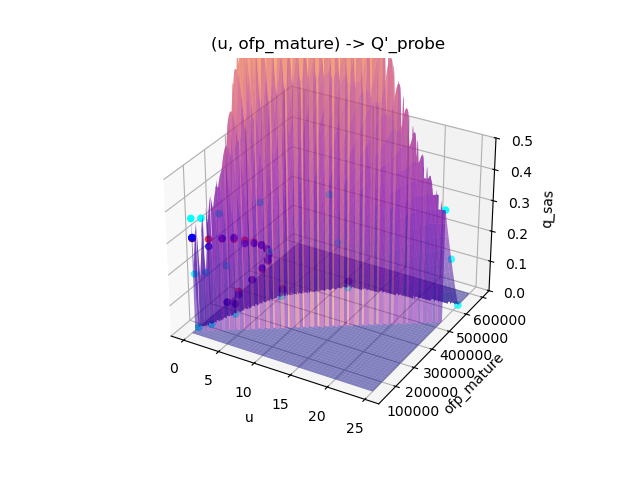

In [18]:
# create figure
q_sas_fig = plt.figure(1)
plt.clf()
q_sas_ax = q_sas_fig.add_subplot(111, projection='3d')

# make a 3D plot of experimentally measured Q values
probe_char_data_q_sas=np.load('../probe_characterisation/Qdash_probe_data.npy')
q_sas_ax.scatter(
    probe_char_data_q_sas[0],
    probe_char_data_q_sas[1],
    probe_char_data_q_sas[2],
    c='cyan',
    label='Measured Q values')
# make a 3D plot of identified steady states
q_sas_ax.scatter(
    uexp_steady_states,
    b_steady_states,
    q_sas_steady_states_est,
    c='blue', alpha=0.75,
    label='Measured Q values')
q_sas_ax.scatter(
    uexp_steady_states,
    b_steady_states,
    q_sas_steady_states,
    c='red', alpha=0.75,
    label='Measured Q values')

# make a 3D plot of experimentally measured Q values
q_sas_ax.plot_surface(
    us_mesh_est,
    y_mesh_est,
    q_sas_mapping_est,
    cmap=mpl.colormaps['plasma'], alpha=0.5,
    label='Mapping')

# q_sas_ax.plot(
#     uexprecord,
#     xs[:, modules_name2pos['b_mature']],
#     q_sass,
#     c='blue', alpha=0.5, label='CBC trajectory')
#
# q_sas_ax.plot(
#     uexprecord,
#     xs[:, modules_name2pos['b_mature']],
#     q_sass_real,
#     c='red', alpha=0.5, label='CBC trajectory')

# format the plot
q_sas_ax.set_title("(u, ofp_mature) -> Q\'_probe")
q_sas_ax.set_xlabel('u')
q_sas_ax.set_ylabel('ofp_mature')
q_sas_ax.set_zlabel('q_sas')
q_sas_ax.set_zlim(0,0.5)

# show plot
plt.show()